# Classification
In this notebook, we will focus on building a classification model using the labeled data we have designed in the second notebook.

We will use LightGBM classifier to build a classification model. We are choosing LightGMB over XGBoost as it is faster and performs well for this type of problem. Let's import all the modules we need and define the functions we will be using.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import lightgbm as lgbm


%matplotlib inline
pd.plotting.register_matplotlib_converters()
sns.set(style = "ticks")

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report  
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score, matthews_corrcoef 
from sklearn.metrics import confusion_matrix

Next, we design our dataset based on the discussions we had in the previous notebook.

In [3]:
file_path = "../data/data.csv"
data = pd.read_csv(file_path, index_col = "consumer_id")

cols_with_na = [col for col in data.columns if data[col].isnull().any()]

data.drop(cols_with_na + ["account_status"], axis = 1, inplace = True)
data_lof = pd.DataFrame(MinMaxScaler().fit_transform(data), index = data.index)
lof = LocalOutlierFactor(n_neighbors=50, contamination=0.1).fit_predict(data_lof)
data_lof.columns = data.columns
data_lof["label"] = lof
data_lof["label"] = data_lof["label"].replace([-1,1],[1,0])
data_lof.head()

,has_gender,has_first_name,has_last_name,has_email,has_dob,account_age,account_last_updated,app_downloads,unique_offer_clicked,total_offer_clicks,unique_offer_rides,total_offer_rides,avg_claims,min_claims,max_claims,total_offers_claimed,label
consumer_id,,,,,,,,,,,,,,,,,
1284b75c-ecae-4015-8e3d-359c0347ede8,0.0,1.0,1.0,1.0,0.0,0.029474,0.071429,0.0,0.153846,0.032787,0.291667,0.029568,0.0,0.0,0.0,0.0,0
128af162-d2c3-4fe4-986c-359c8bdc6c04,0.0,1.0,1.0,1.0,0.0,0.023158,0.071429,0.0,0.153846,0.114754,0.166667,0.033116,0.0,0.0,0.0,0.0,0
12aada5e-36eb-4e9e-8d62-359c076c1b40,0.0,1.0,1.0,1.0,0.0,0.029474,0.071429,0.0,0.153846,0.049180,0.333333,0.107037,0.0,0.0,0.0,0.2,0
12c2e02f-bc79-4048-83ba-359cd3280dcf,0.0,1.0,1.0,1.0,0.0,0.021053,0.071429,0.0,0.153846,0.098361,0.125000,0.031934,0.0,0.0,0.0,0.0,0
12fabdf0-0582-489e-a6d3-35509ab8ae6f,1.0,1.0,1.0,1.0,1.0,0.837895,0.000000,0.0,0.230769,0.081967,0.250000,0.047901,0.0,0.0,0.0,0.2,0


Next, we separate our target from the dataset and generate train and test datasets.

In [4]:
X = data_lof.drop(["label"], axis = 1)
y = data_lof["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train.shape

(8000, 16)

## Hyperparameter Optimisation
We will do a grid search to get to find the optimised values for `learning_rate`, `n_estimators` and `num_leaves`.

In [65]:
est_model = lgbm.LGBMClassifier(learning_rate=0.1, n_estimators=20, num_leaves=5)

param_grid = {
    "n_estimators": [i for i in range(20, 40, 2)],
    "learning_rate": [0.10, 0.125, 0.15, 0.175, 0.2],
    "num_leaves": [i for i in range(5, 40, 5)]
}

grid_search = GridSearchCV(est_model, param_grid,cv = 10)

grid_search.fit(
    X_train, y_train,
    eval_set = [(X_test, y_test)],
    eval_metric = ["auc", "binary_logloss"],
    verbose = 0
)

GridSearchCV(cv=10, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=20,
                                      n_jobs=-1, num_leaves=5, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.125, 0.15, 0.175, 0.2],
                     

After the optimisation, we can easily the the optimum parameters from the grid search.

In [66]:
print('Best parameters found by grid search are:', grid_search.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.2, 'n_estimators': 34, 'num_leaves': 35}


Using these optimised values, we define our model as follows.

In [5]:
lgmb_model = lgbm.LGBMClassifier(learning_rate=0.2, n_estimators=34, num_leaves=35)

lgmb_model.fit(
    X_train, y_train,
    eval_set = [(X_test, y_test)],
    eval_metric = ["auc", "binary_logloss"]
)

[1]	valid_0's auc: 0.901732	valid_0's binary_logloss: 0.237438
[2]	valid_0's auc: 0.902298	valid_0's binary_logloss: 0.217146
[3]	valid_0's auc: 0.93011	valid_0's binary_logloss: 0.197986
[4]	valid_0's auc: 0.938305	valid_0's binary_logloss: 0.182911
[5]	valid_0's auc: 0.940201	valid_0's binary_logloss: 0.172339
[6]	valid_0's auc: 0.94751	valid_0's binary_logloss: 0.163112
[7]	valid_0's auc: 0.946825	valid_0's binary_logloss: 0.156471
[8]	valid_0's auc: 0.947649	valid_0's binary_logloss: 0.151413
[9]	valid_0's auc: 0.954898	valid_0's binary_logloss: 0.145539
[10]	valid_0's auc: 0.961813	valid_0's binary_logloss: 0.140301
[11]	valid_0's auc: 0.963125	valid_0's binary_logloss: 0.136415
[12]	valid_0's auc: 0.964294	valid_0's binary_logloss: 0.132328
[13]	valid_0's auc: 0.965251	valid_0's binary_logloss: 0.130425
[14]	valid_0's auc: 0.966337	valid_0's binary_logloss: 0.12684
[15]	valid_0's auc: 0.966782	valid_0's binary_logloss: 0.125469
[16]	valid_0's auc: 0.966604	valid_0's binary_loglos

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.2, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=34, n_jobs=-1, num_leaves=35, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Metrics, ROC Curve and Confusion Matrix
In this section, we calculate important metrics, plot the ROC curve and present the confusion matrix.

In [6]:
y_pred = lgmb_model.predict(X_test, num_iteration=lgmb_model.best_iteration_)

acc = accuracy_score(y_test, y_pred) 
print("The accuracy is {}".format(acc)) 
  
prec = precision_score(y_test, y_pred) 
print("The precision is {}".format(prec)) 
  
rec = recall_score(y_test, y_pred) 
print("The recall is {}".format(rec)) 
  
f1 = f1_score(y_test, y_pred) 
print("The F1-Score is {}".format(f1)) 
  
MCC = matthews_corrcoef(y_test, y_pred) 
print("The Matthew's correlation coefficient is {}".format(MCC)) 

The accuracy is 0.9625
The precision is 0.8545454545454545
The recall is 0.734375
The F1-Score is 0.7899159663865547
The Matthew's correlation coefficient is 0.7721216255310057


Next, we will plot the ROC curve. For that, we need to prediction probabilities and calculate the thresholds.

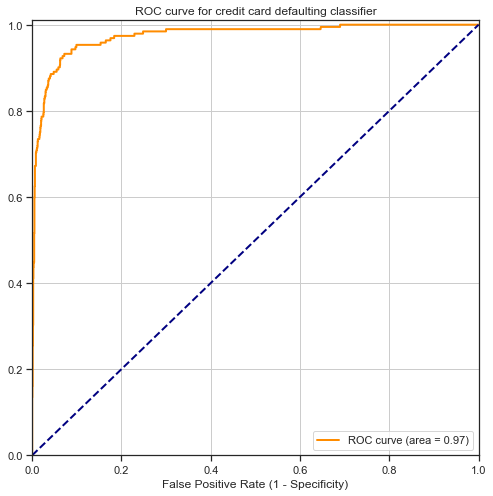

In [90]:
y_pred_p = lgmb_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_p)

plt.figure(figsize = (8, 8))
plt.plot(fpr, tpr, color = "darkorange", lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred_p))
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.title('ROC curve for credit card defaulting classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("p_roc.png")

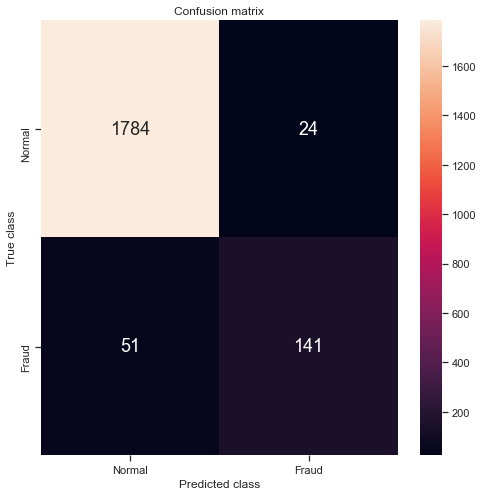

In [92]:
axis_labels = ['Normal', 'Fraud'] 
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (8, 8)) 
sns.heatmap(
    conf_matrix,
    xticklabels = axis_labels,  
    yticklabels = axis_labels,
    annot = True,
    fmt ="d"
) 
plt.title("Confusion matrix") 
plt.ylabel('True class') 
plt.xlabel('Predicted class') 
plt.savefig("p_cf.png")

## Conclusion
Although we have an unbalanced dataset, our Matthew's correlation coefficient together with precision and recall tells us that out model is able to classify the cases rather accurately. We suspect these scores can be raised higher with trying different sampling methods to balance the dataset.